# Practical Introduction to Digital Filtering in Python


**Author** : Falak Shah


Based on [this excellent Mathworks tutorial ](https://in.mathworks.com/help/signal/examples/practical-introduction-to-digital-filtering.html) on the same subject.

This example shows how to design, analyze, and apply a digital filter to your data. It will help you answer questions such as: 
* How do I compensate for the delay introduced by a filter?, 
* How do I avoid distorting my signal?, 
* How do I remove unwanted content from my signal?
* How do I differentiate my signal?, and How do I integrate my signal?

Filters can be used to shape the signal spectrum in a desired way or to perform mathematical operations such as differentiation and integration. In what follows you will learn some practical concepts that will ease the use of filters when you need them.

This example focuses on applications of digital filters rather than on their design. If you want to learn more about how to design digital filters see the Practical Introduction to Digital Filter Design example.

In [ ]:
# Using neurokit2 for generating synthetic EEG signal
! pip install neurokit2

In [ ]:
% matplotlib inline
from matplotlib import pyplot as plt
from scipy import signal
import numpy as np
import neurokit2 as nk  # Load the package
import scipy
from scipy.io import wavfile

In [ ]:
def plot_response(fs, w, h, title="Low-pass Filter",label='', ax=None, ylim=-70):
    "Utility function to plot response functions"
    if not ax:
      fig = plt.figure()
      ax = fig.add_subplot(111)
    ax.plot(0.5*fs*w/np.pi, 20*np.log10(np.abs(h)), label=label)
    ax.set_ylim(ylim, 5)
    ax.set_xlim(0, 0.5*fs)
    ax.grid(True)
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Gain (dB)')
    ax.set_title(title)
    ax.legend()
    return ax

## Compensating for Delay Introduced by Filtering


Digital filters introduce delay in your signal. Depending on the filter characteristics, the delay can be constant over all frequencies, or it can vary with frequency. The type of delay determines the actions you have to take to compensate for it. The grpdelay function allows you to look at the filter delay as a function of frequency. Looking at the output of this function allows you to identify if the delay of the filter is constant or if it varies with frequency (i.e. if it is frequency-dependent).

Filter delay that is constant over all frequencies can be easily compensated for by shifting the signal in time. FIR filters usually have constant delay. On the other hand, delay that varies with frequency causes phase distortion and can alter a signal waveform significantly. Compensating for frequency-dependent delay is not as trivial as for the constant delay case. IIR filters introduce frequency-dependent delay.

### Compensating for Constant Filter Delay

As mentioned before, you can measure the group of delay of the filter to verify that it is a constant function of frequency. You can use the grpdelay function to measure the filter delay, D, and compensate for this delay by appending D zeros to the input signal and shifting the output signal in time by D samples.

Consider a noisy electrocardiogram signal that you want to filter to remove high frequency noise above 75 Hz. You want to apply an FIR lowpass filter and compensate for the filter delay so that the noisy and filtered signals are aligned correctly and can be plotted on top of each other for comparison.

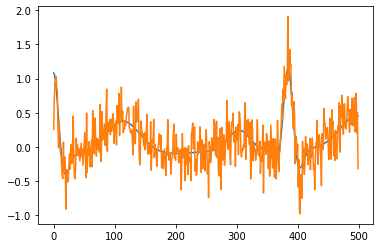

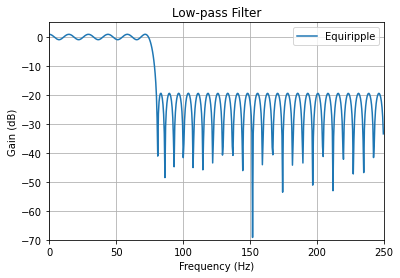

In [ ]:
fs = 500;                   # sample rate in Hz
N = 500;                    #  number of signal samples


ecg = nk.ecg_simulate(duration=int(N/fs), sampling_rate=fs, heart_rate=80)
plt.plot(ecg)
x = ecg + 0.25 * np.random.randn(N); # noisy waveform
plt.plot(x)
t = np.arange(N)/fs;              # time vector

# Design a 70th order lowpass FIR filter with cutoff frequency of 75 Hz.

fc = 75      # Normalized frequency
filtord = 70
# df = designfilt('lowpassfir','FilterOrder',70,'CutoffFrequency',Fnorm);
taps = signal.remez(filtord, [0, 75, 80, 250],[1, 0], fs = fs)
w, h = signal.freqz(taps, [1])
plot_response(fs, w, h, label='Equiripple', title="Low-pass Filter")

In [ ]:
# grpdelay(df,2048,Fs)   % plot group delay
# D = mean(grpdelay(df)) % filter delay in samples

w, gd_fir = signal.group_delay([taps, np.ones(1)])

In [ ]:
group_delay = int(np.ceil(np.mean(gd_fir)))
print(group_delay)

35


Plot the group delay of the filter to verify that it is constant across all frequencies indicating that the filter is linear phase. Use the group delay to measure the delay of the filter.

(0.0, 50.0)

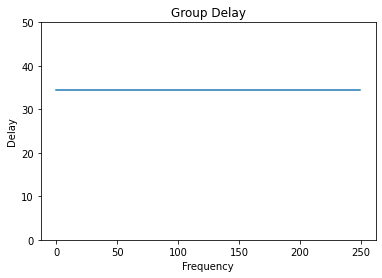

In [ ]:
plt.plot(w/np.pi*fs/2, gd_fir)
plt.title('Group Delay')
plt.xlabel('Frequency')
plt.ylabel('Delay')
plt.ylim([0,50])


Before filtering, append D zeros at the end of the input data vector, x. This ensures that all the useful samples are flushed out of the filter, and that the input signal and the delay-compensated output signal have the same length. Filter the data and compensate for the delay by shifting the output signal by D samples. This last step effectively removes the filter transient.

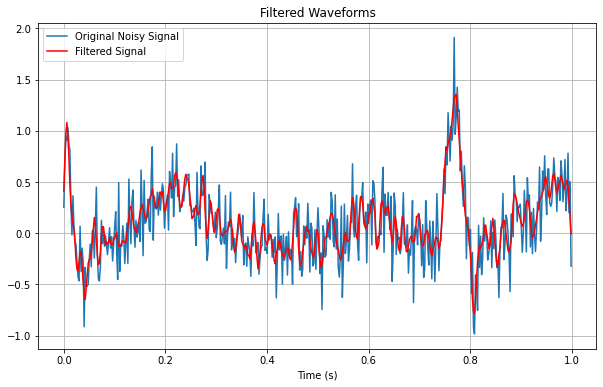

In [ ]:
# y = filter(df,[x; zeros(D,1)]); % Append D zeros to the input data
y = signal.lfilter(taps, 1, np.concatenate([x, np.zeros(group_delay)]))
y = y[group_delay:]                  # Shift data to compensate for delay

plt.figure(figsize=[10,6])
plt.plot(t,x)
plt.plot(t,y, 'r')
plt.title('Filtered Waveforms');
plt.xlabel('Time (s)')
plt.grid()
plt.legend(['Original Noisy Signal','Filtered Signal']);
# grid on
# axis tight

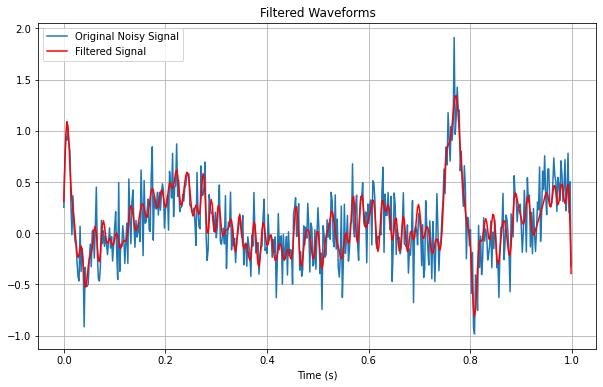

In [ ]:
y = signal.filtfilt(taps, 1, x)
           # Shift data to compensate for delay

plt.figure(figsize=[10,6])
plt.plot(t,x)
plt.plot(t,y, 'r')
plt.title('Filtered Waveforms');
plt.xlabel('Time (s)')
plt.grid()
plt.legend(['Original Noisy Signal','Filtered Signal']);

## Compensating for Frequency-Dependent Delay

Frequency-dependent delay causes phase distortion in the signal. Compensating for this type of delay is not as trivial as for the constant delay case. If your application allows off-line processing, you can remove the frequency-dependent delay by implementing zero-phase filtering using the filtfilt function. filtfilt performs zero-phase filtering by processing the input data in both the forward and reverse directions. The main effect is that you obtain zero-phase distortion, i.e., you filter data with an equivalent filter that has a constant delay of 0 samples. Other effects are that you get a filter transfer function which equals the squared magnitude of the original filter transfer function, and a filter order that is double the order of the original filter.

Consider the ECG signal defined in the previous section. Filter this signal with and without delay compensation.

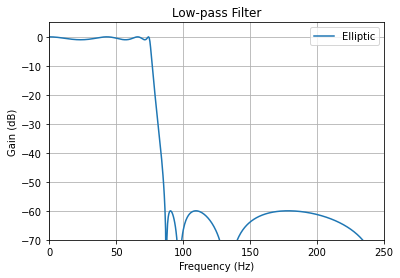

In [ ]:
filtord = 7
fpass = 75
Apass = 1
Astop = 60
fs = 500

system_ellip = signal.iirfilter(filtord, fpass, Apass, Astop, btype='lowpass',
                         ftype='ellip', output='ba', fs=fs)
w, h = signal.freqz(*system_ellip)
plot_response(fs, w, h, label='Elliptic')

Plot the group delay of the filter and notice that it varies with frequency indicating that the filter delay is frequency-dependent.

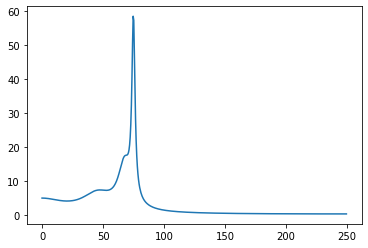

In [ ]:
w, gd_iir = signal.group_delay(system_ellip)
plt.plot(w/np.pi*fs/2, gd_iir)

Filter the data and look at the effects of each filter implementation on the time signal.

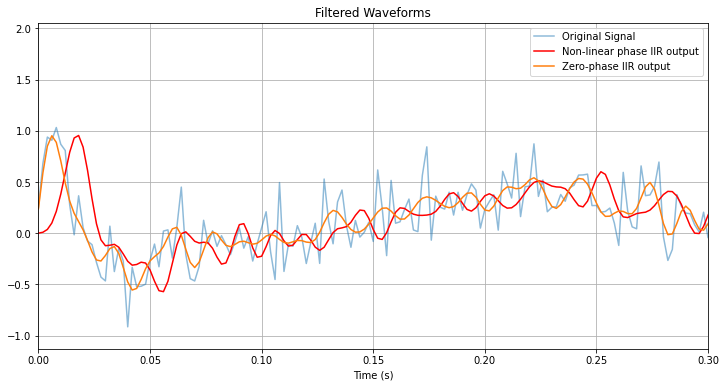

In [ ]:
y1 = signal.lfilter(*system_ellip, x);    # non-linear phase filter - no delay compensation
y2 = signal.filtfilt(*system_ellip, x);  # zero-phase implementation - delay compensation

plt.figure(figsize=[12,6])
plt.plot(t,x, '-', alpha=0.5);
plt.plot(t,y1,'r');
plt.plot(t,y2);
plt.title('Filtered Waveforms');
plt.xlabel('Time (s)')
plt.legend(['Original Signal','Non-linear phase IIR output',
  'Zero-phase IIR output']);

plt.xlim([0, 0.3])
plt.grid()

Notice how zero-phase filtering effectively removes the filter delay.

Zero-phase filtering is a great tool if your application allows for the non-causal forward/backward filtering operations, and for the change of the filter response to the square of the original response.

Filters that introduce constant delay are linear phase filters. Filters that introduce frequency-dependent delay are non-linear phase filters.

## Removing Unwanted Spectral Content from a Signal
Filters are commonly used to remove unwanted spectral content from a signal. You can choose from a variety of filters to do this. You choose a lowpass filter when you want to remove high frequency content, or a highpass filter when you want to remove low frequency content. You can also choose a bandpass filter to remove low and high frequency content while leaving an intermediate band of frequencies intact. You choose a bandstop filter when you want to remove frequencies over a given band.

Consider an audio signal that has a hum and white noise. The power-line hum is caused by a 400 Hz tone. White noise is a signal that exists across all the audio bandwidth.
 
Wav file sources: [MIT lab handout](http://web.mit.edu/6.02/www/f2010/handouts/labs/lab6/lab6.shtml)

Load the audio signal

In [ ]:
! wget -c https://raw.githubusercontent.com/falaktheoptimist/pydsp_tutorials/master/Filtering/data/hum_testsound.wav
! wget -c https://raw.githubusercontent.com/falaktheoptimist/pydsp_tutorials/master/Filtering/data/testsound.wav

--2020-08-12 07:39:31--  https://raw.githubusercontent.com/falaktheoptimist/pydsp_tutorials/master/Filtering/data/hum_testsound.wav
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 416 Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

--2020-08-12 07:39:38--  https://raw.githubusercontent.com/falaktheoptimist/pydsp_tutorials/master/Filtering/data/testsound.wav
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 416 Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



In [ ]:
fs, clean_wav = wavfile.read('testsound.wav') # Noise free sound file
fs, hum_wav = wavfile.read('hum_testsound.wav') # File with noise
print(len(clean_wav), len(hum_wav), fs)
hum_wav = hum_wav[:fs*20]
clean_wav = clean_wav[:fs*20]

643520 643520 22050


Plot the power spectrum of the signal. The red line shows the strong 400 Hz tone interfering with the audio signal.

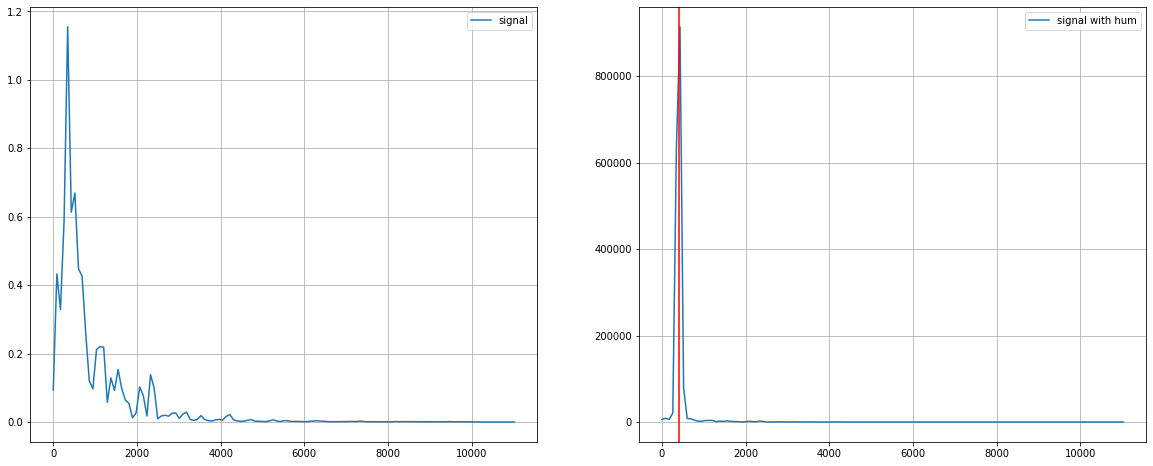

In [ ]:
plt.figure(figsize=[20,8])
plt.subplot(1,2,1)
freq, power = signal.welch(clean_wav , fs)
plt.plot(freq, power, label='signal')
plt.legend()
plt.grid()
plt.subplot(1,2,2)
freq_hum, power_hum = signal.welch(hum_wav , fs)
plt.plot(freq_hum, power_hum, label='signal with hum')
plt.axvline(x=400, color='r')
plt.legend()
plt.grid()

You can first remove as much white noise spectral content as possible using a lowpass filter. The passband of the filter should be set to a value that offers a good trade-off between noise reduction and audio degradation due to loss of high frequency content. Applying the lowpass filter before removing the 400 Hz hum is very convenient since you will be able to downsample the band-limited signal. The lower rate signal will allow you to design a sharper and narrower 400 Hz bandstop filter with a smaller filter order.

Design a lowpass filter with passband frequency of 3 kHz, and stopband frequency of 3.5 kHz. 

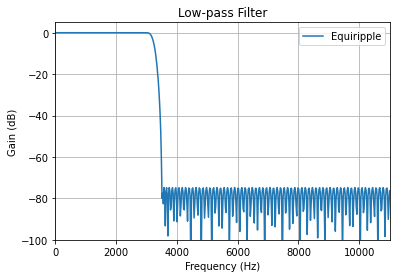

In [ ]:
fpass = 3e3;    # Passband frequency in Hz
fstop = 3.5e3; # Stopband frequency in Hz
apass = 1;      # Passband ripple in dB
astop = 95;    # Stopband attenuation in dB

filtord = np.ceil(fs/(fstop-fpass) * (astop/22)).astype(np.int32)
taps = signal.remez(filtord, [0, fpass, fstop, fs/2], [1, 0], fs = fs)
w, h = signal.freqz(taps, [1])
ax = plot_response(fs, w, h, label='Equiripple', title="Low-pass Filter", ylim=-100)

Look at the spectrum of the lowpass filtered signal. Note how the frequency content above 3500 Hz has been removed.

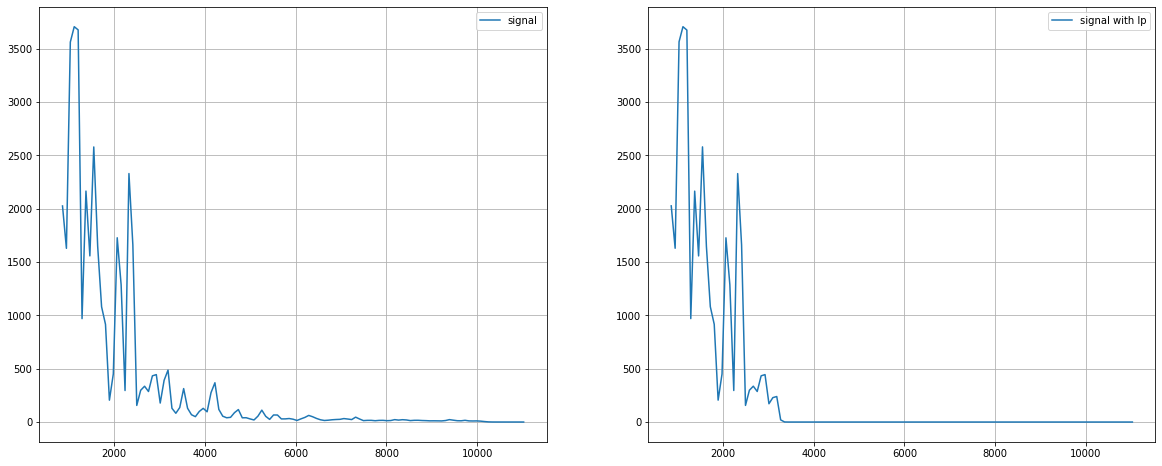

In [ ]:
n = 10
ylp = signal.filtfilt(taps, 1, hum_wav)
plt.figure(figsize=[20,8])
plt.subplot(1,2,1)
freq, power = signal.welch(hum_wav , fs)
plt.plot(freq[n:], power[n:], label='signal')
plt.legend()
plt.grid()
plt.subplot(1,2,2)
freq, power = signal.welch(ylp , fs)
plt.plot(freq[n:], power[n:], label='signal with lp')
plt.legend()
plt.grid()

From the power spectrum plot above, you can see that the maximum non-negligible frequency content of the lowpass filtered signal is at 3500 Hz. By the sampling theorem, a sample frequency of 2*3500 = 7000 Hz would suffice to represent the signal correctly, you however, are using a sample rate of 44100 Hz which is a waste since you will need to process more samples than those necessary. You can downsample the signal to reduce the sample rate and reduce the computational load by reducing the number of samples that you need to process. A lower sample rate will also allow you to design a sharper and narrower bandstop filter, needed to remove the 60 Hz noise, with a smaller filter order.

Downsample the lowpass filtered signal by a factor of 5 to obtain a sample rate of Fs/5 = 8.82 kHz. 

In [ ]:
fsds = fs/5
yds = scipy.signal.decimate(ylp,5);

In [ ]:
# freq, power = signal.welch(yds , fsds)
# plt.plot(freq, power, label='signal with lp+ds')

# plt.legend()
# plt.grid()

In [ ]:
print(ylp.shape, yds.shape)

(441000,) (88200,)


Now remove the 400 Hz tone using an IIR bandstop filter. Let the stopband have a width of 30 Hz centered at 400 Hz. We choose an IIR filter to achieve a sharp frequency notch, small passband ripple, and a relatively low order. Process the data using filtfilt to avoid phase distortion.

In [ ]:
system_ellip = signal.iirdesign([370, 430], [390, 410], 
                                1, 70, ftype='ellip', fs=fsds)

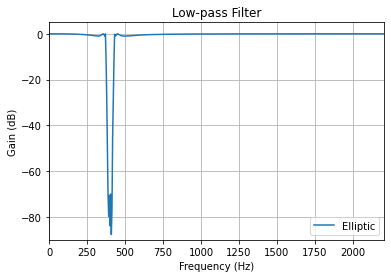

In [ ]:
w, h = signal.freqz(*system_ellip)
plot_response(fsds, w, h, label='Elliptic', ylim=-90)

Perform zero-phase filtering to avoid distortion

In [ ]:
ybs = signal.filtfilt(*system_ellip, yds);

Finally, upsample the signal to bring it back to the original audio sample rate of 44.1 kHz which is compatible with audio soundcards

In [ ]:
yf = signal.resample(ybs, ybs.shape[0]*5);

Take a final look at the spectrum of the original and processed signals. Notice how the high frequency noise floor and the 400 Hz tone have been attenuated by the filters.

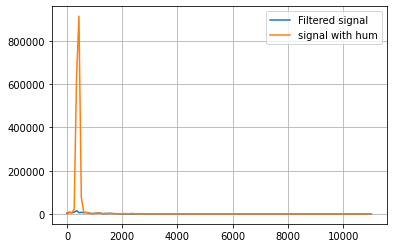

In [ ]:
freq, power = signal.welch(yf , fs)
plt.plot(freq, power, label='Filtered signal')
plt.plot(freq_hum, power_hum, label='signal with hum')
plt.legend()
plt.grid()

Listen to the signal before and after processing. As mentioned above, the end result is that you have effectively attenuated the 400 Hz hum and the high frequency noise on the audio file.

Normalizing values before writing out to wav.

In [ ]:
yfn = np.uint8((yf-np.min(yf))/(np.max(yf)  - np.min(yf))*255)
wavfile.write('out.wav', fs, yfn)

In [ ]:
from IPython.display import Audio
Audio(data=yf, rate=fs)

In [ ]:
Audio(data=hum_wav, rate=fs)

Yay! It works :)